In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.iterables import all_connectivities
from pathlib import Path

In [2]:
df_pos = pd.read_csv(
    Path("edge_counts") / "blockwise_positive_schaefer200_thresholded.csv",
    index_col=0
).rename({"0": "edge_count"}, axis="columns")
df_neg = pd.read_csv(
    Path("edge_counts") / "blockwise_negative_schaefer200_thresholded.csv",
    index_col=0
).rename({"0": "edge_count"}, axis="columns")

block_sizes = pd.read_csv(
    "edge_counts/blockwise_block_size_schaefer200_thresholded.csv",
    index_col=0
).rename({"0": "edge_count"}, axis="columns")

In [3]:
df = df_pos.copy()
df["edge_count"] = df_pos.edge_count - df_neg.edge_count
df["edge_count"] = df["edge_count"] / block_sizes.edge_count
df["sorted_pair"] = df.apply(lambda row: tuple(sorted([row['node_a'], row['node_b']])), axis=1)
df= df.drop_duplicates(subset=['sorted_pair', "cluster_label", "fold"])

In [4]:
# We need reference from a meaningful baseline, so substract the median edge count of stable to the other classes
networks = df.node_a.unique()
stable_msk = (df.cluster_label == 0)
df_scaled = df.copy().loc[~stable_msk]
for net_a, net_b in all_connectivities(networks):
    ref_net_msk = (df.node_a == net_a) & (df.node_b == net_b)
    target_net_msk = (df_scaled.node_a == net_a) & (df_scaled.node_b == net_b)

    # All stable values across folds
    ref_values = df[ref_net_msk & stable_msk]["edge_count"]
    
    ref_value = np.quantile(ref_values, 0.5, method="closest_observation")

    df_scaled.loc[target_net_msk, "edge_count"] -= ref_value

In [5]:
df_scaled

,node_a,node_b,edge_count,cluster_label,fold,sorted_pair
0,Cont,Cont,-0.053333,1,0,"(Cont, Cont)"
1,Cont,Default,-0.013043,1,0,"(Cont, Default)"
2,Cont,DorsAttn,-0.021795,1,0,"(Cont, DorsAttn)"
3,Cont,Limbic,0.013889,1,0,"(Cont, Limbic)"
4,Cont,SalVentAttn,-0.031818,1,0,"(Cont, SalVentAttn)"
...,...,...,...,...,...,...
33,SalVentAttn,SomMot,-0.036364,2,7,"(SalVentAttn, SomMot)"
34,SalVentAttn,Vis,0.000000,2,7,"(SalVentAttn, Vis)"
40,SomMot,SomMot,-0.114286,2,7,"(SomMot, SomMot)"
41,SomMot,Vis,-0.027586,2,7,"(SomMot, Vis)"


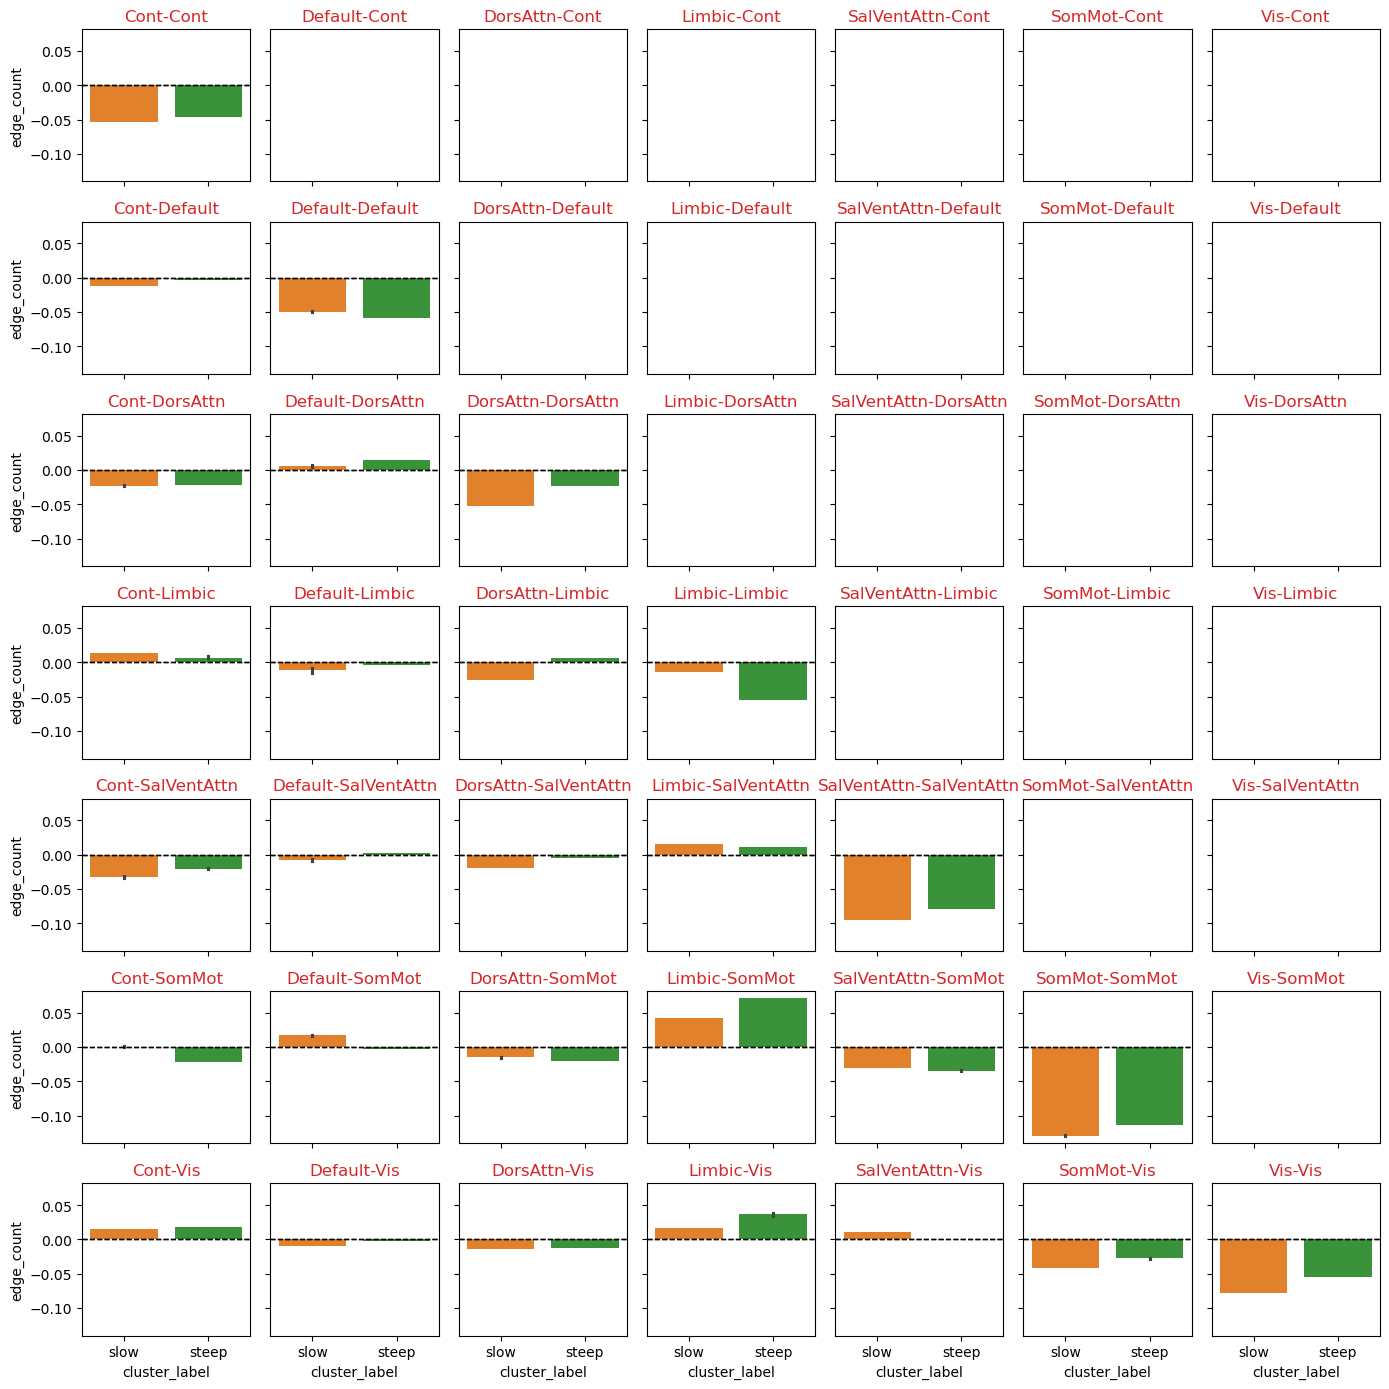

In [6]:
grid = sns.FacetGrid(
    df_scaled,
    col="node_a",
    row="node_b",
    hue="cluster_label",
    palette=("tab:orange", "tab:green"),
    margin_titles=False,
    sharex=True,
    sharey=True,
    despine=False,
    height=2
)
grid.set_titles(
    template="{col_name}-{row_name}",
    row_template="{row_name}",
    col_template="{col_name}",
    color="tab:red", fontweight="roman", size="large"
)
grid.map_dataframe(sns.barplot, "cluster_label", "edge_count")
#grid.map(sns.barplot, "cluster_label", "edge_count")
#grid.set(xticks=[1, 2])
grid.set_xticklabels(("slow", "steep"))
#grid.set_xlabels("")

grid.map(lambda **kwargs: plt.axhline(0, color="black", linestyle="--", linewidth=1))
